## Spatial Autocorrelation and Regression Analysis
In this tutorial, you will calculate a global Moran's I statistic to evaluate spatial autocorrelation in your data, and then explore different methods to account for spatial autocorrelation in your data. Specifically, we'll compare parameter estimates relating county income to 2016 county voting preferences using an OLS model, and autoregressive model, and an autocovariance function model.


In [1]:
!pip install pysal
!pip install libpysal
!pip insall geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 12.7 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 60 kB 7.1 MB/s 
     |████████████████████████████████| 220 kB 45.3 MB/s 
     |████████████████████████████████| 5.7 MB 40.6 MB/s 
     |████████████████████████████████| 147 kB 43.0 MB/s 
     |████████████████████████████████| 41 kB 603 kB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 243 kB 8.8 MB/s 
     |████████████████████████████████| 46 kB 3.0 MB/s 
     |████████████████████████████████| 116 kB 48.9 MB/s 
     |████████████████████████████████| 1.0 MB 48.5 MB/s 
     |████████████████████████████████| 179 kB 58.3 MB/s 
     |████████████████████████████████| 2.1 MB 45.0 MB/s 
     |████████████████████████████████| 16.7 MB 46.2 MB/s 
     |████████████████████████████████| 6

In [2]:
import pysal as ps
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights.contiguity import Queen
import libpysal
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran_Local
from esda.moran import Moran
from statsmodels.api import OLS
from pysal.model import spreg
sns.set_style('white')

First, we're going to open 'Elections' dataset from the Geodata Center at the University of Chicago.

* More on spatial data science resources from UC: https://spatial.uchicago.edu/
* A list of datasets available through lipysal: https://geodacenter.github.io/data-and-lab//

Using our multicollinearity.ipynb, we downloaded this dataset to *H:/EnvDatSci/election/election.shp*

**Note: it may be on a different location on your computer**

### TASK 1: access the "election" shapefile used in the multicollinearity.ipnb script

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Task 1
votes = gpd.read_file("drive/MyDrive/data/Test/election/election.shp")

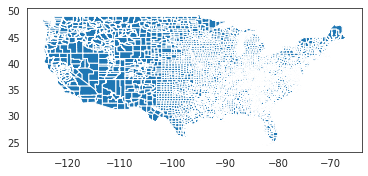

In [6]:
#Let's view the shapefile to get a general idea of the geometry we're looking at:
%matplotlib inline
votes.plot()

In [7]:
#View the first few line]s of the dataset
votes.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,total_2012,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry
0,01,005,01005,2.291821e+09,50864677.0,Barbour County,AL,26887.0,27457.0,-2.1,...,11459.0,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.748 31.619, -85.745 31.619, -85...."
1,01,023,01023,2.365955e+09,19059247.0,Choctaw County,AL,13323.0,13858.0,-3.9,...,7965.0,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.473 31.894, -88.469 31.930, -88...."
2,01,035,01035,2.201896e+09,6643480.0,Conecuh County,AL,12670.0,13228.0,-4.2,...,7013.0,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.427 31.264, -87.426 31.268, -87...."
3,01,051,01051,1.601877e+09,99850740.0,Elmore County,AL,80977.0,79296.0,2.1,...,35440.0,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.413 32.751, -86.371 32.751, -86...."
4,01,065,01065,1.667805e+09,32525874.0,Hale County,AL,15184.0,15760.0,-3.7,...,8628.0,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.870 32.762, -87.868 32.766, -87...."


In our multicollinearity notebook, we visualized the voting trends, and the change in voting trends, in space. First we created a new column indicating the percent change in democratic vote. Then we plotted the percent democratic vote in 2012, the percent democratic vote in 2016, and the percent change in democratic vote as maps and using global histograms.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


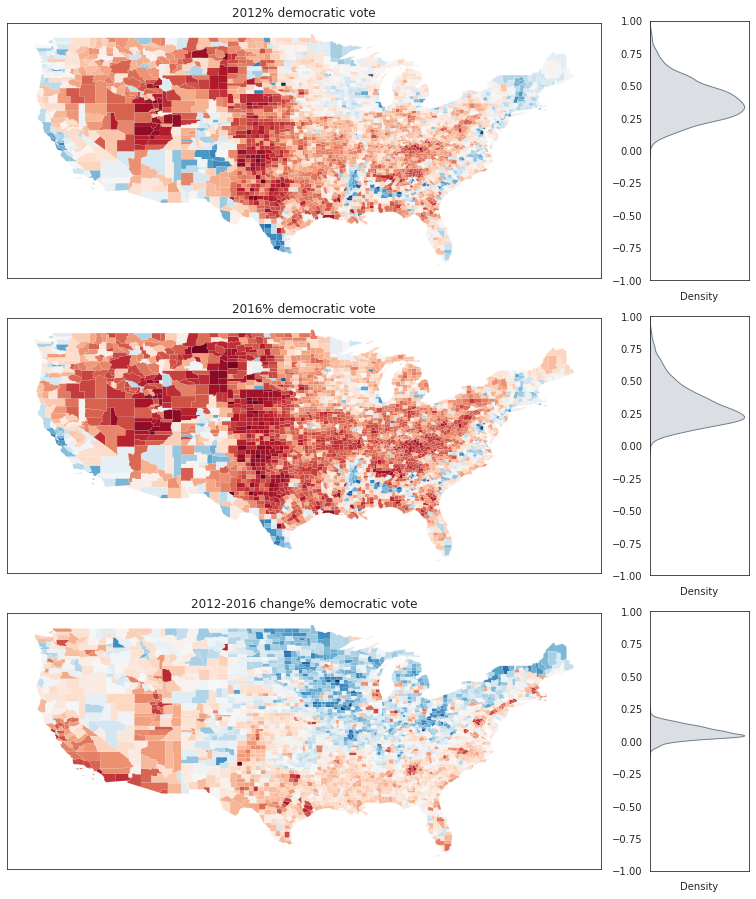

In [8]:
# Add new column pct_dem_change to votes:
votes['pct_dem_change'] = votes['pct_dem_12'] - votes['pct_dem_16']

f,ax = plt.subplots(3,2, figsize=(1.6*6 + 1,4.2*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16', 'pct_dem_change']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    ax[i,0].set_title(['2012','2016', '2012-2016 change'][i] + "% democratic vote")
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

### Spatial Autocorrelation
From https://www.sciencedirect.com/topics/computer-science/spatial-autocorrelation 

>"Spatial autocorrelation is the term used to describe the presence of *systematic* spatial variation in a variable and positive spatial autocorrelation, which is most often encountered in practical situations, is the tendency for areas or sites that are close together to have similar values."

### TASK 2: Do you see evidence for *spatial autocorrelation* in the three plots above? If so, describe the evidence that you see.

Answer:
Yes there are some evidence of autocorrelation. For example in third figure south-western section of united states is more colored toward red, while areas in north-eastern are in the blue range.
This trend is more strong in first two figures in which the central and western areas are mostly colored in shades of red.



## Was the county wide percent change in democratic vote related to per capita income?
The next question is how can we use robust statistics to determine whether per capita income or the county land area were related to a change in 2016 voting preferences. To do this, we're going to conduct a linear regression relating our parameters pct_dem_change to INC910213 and ALAND. Then, we're going to use the confidence interval around beta hat (our slope parameter estimate) to determine whether the relationships between INC910213, ALAND, and pct_dem_change are significantly different than zero.

First we're going to visualize how these variables relate in the global data:

In [9]:
votes.dropna(subset=['pct_dem_12','pct_dem_16'], inplace=True)

0.9464235104255706
-0.24471033010257184
-0.08312272316914267
-0.014495571366592337


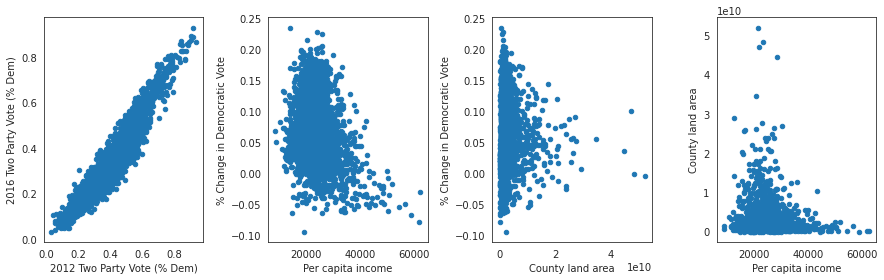

In [10]:
f,ax = plt.subplots(1,4, figsize=(4*3.1,4))

votes[['pct_dem_12','pct_dem_16']].plot.scatter('pct_dem_12','pct_dem_16', ax=ax[0])
ax[0].set_xlabel('2012 Two Party Vote (% Dem)')
ax[0].set_ylabel('2016 Two Party Vote (% Dem)')
print(np.corrcoef(votes['pct_dem_12'].values, votes['pct_dem_16'].values)[0,1])


votes[['INC910213','pct_dem_change']].plot.scatter('INC910213','pct_dem_change', ax=ax[1])
ax[1].set_xlabel('Per capita income')
ax[1].set_ylabel('% Change in Democratic Vote')
print(np.corrcoef(votes['pct_dem_change'].values, votes['INC910213'].values)[0,1])

votes[['ALAND','pct_dem_change']].plot.scatter('ALAND','pct_dem_change', ax=ax[2])
ax[2].set_xlabel('County land area')
ax[2].set_ylabel('% Change in Democratic Vote')
print(np.corrcoef(votes['pct_dem_change'].values, votes['ALAND'].values)[0,1])

votes[['INC910213','ALAND']].plot.scatter('INC910213','ALAND', ax=ax[3])
ax[3].set_xlabel('Per capita income')
ax[3].set_ylabel('County land area')
print(np.corrcoef(votes['INC910213'].values, votes['ALAND'].values)[0,1])

f.tight_layout()
plt.show()

### TASK 3: Do we have significant collinearity in our data?

Answer:
Yes there is evidence of strong collinearity.



What we're looking at in the first plot is the 2012 percent democratic vote, the second plot is the 2016 percent democratic vote, the third plot is the 2012 and 2016 percent democratic vote. In the fourth plot, we're looking at how per capital income (x axis) relates to % change in democratic vote. We want to establish a trendline in the fourth plot using linear regression, and determine of the slope in that trendline is statistically significant.

### TASK 4: what are some features of this data that it look well-suited for linear regression? What are some features of this data that make it poorly suited for linear regression?

Answer:
There is a negative correlation between per capita income and %change in Democratic vote.The 2012 and 2016 Two Party votes are in good linear condition. These two may be well-suited for linear regression.

The "%change in Democratic vote" and "County land Area" are poorly ditributed and have low correlation together. Same situation is also evidented between "Per Capita income" and "County land area".

## Do we have spatial autocorrelation in our data?
When we're looking at distributions of voting preferences, remember that we're aggregating these numbers over arbitrary (er...political) geographic regions. 

Each column in that dataframe represents a data value summarized over a US county, but US counties have widely different land areas and populations:

Text(0.5, 0, '2014 County Population')

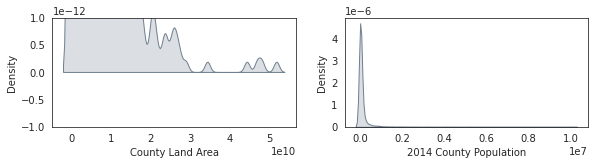

In [11]:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
sns.kdeplot(votes['ALAND'].values, shade=True, color='slategrey', ax=ax[0])
ax[0].set_xlabel('County Land Area')

sns.kdeplot(votes['PST045214'].values, shade=True, color='slategrey', ax=ax[1])
ax[1].set_xlabel('2014 County Population')

Our *spatial sampling rate* (by county) may not accurately represent the spatial frequency of variability in voting preferences and/or income. 

First, let's focus on the spatial componnet: the fact that these counties are different sizes. 

If we want to identify spatial autocorrelation in our data, we need to first understand how this spatial autocorrelation decays as a function of distance. 

To do this, we calculate the Moran's I statistic, which you can think of as the "slope" that we'd get when we regress data values for all geographic entities with data values that neighbor within a given distance. Lets look at our data in lat/lon space again:

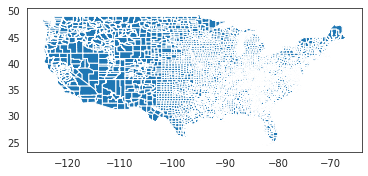

In [12]:
votes.plot()

In [13]:
votes.crs

<Projected CRS: PROJCS["Equidistant_Cylindrical",GEOGCS["WGS 84",D ...>
Name: Equidistant_Cylindrical
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Equidistant Cylindrical
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### TASK 5: What is the horizontal unit (unit of distance) in our votes data?

Answer: Meter



One issue is that we're sampling spatially at a distinct, and heterogenous, granulatiry. The smallest unit of measurement available in our dataset is the county level. Counties are different sizes. How can we evaluate whether this spatial sampling granularity is of sufficient resolution to capture the scale of variability in our dataset?

* If we are sampling at too course of a spatial scale, we run the risk of missing key patterns of variability in our data (**UNDERSAMPLING**) 

* If we are sampling at too fine of a sptial scale, we run the risk of violating assumptions of independence between our individual observations (**OVERSAMPLING**)

### TASK 6: In your own words, describe how the spatial sampling scale of "county" might represent and oversampling or undersampling of data as it relates to our question (did per capita income or land area impact change in voting preference



## Calculating a weights matrix:
The first thing we want to tackle is a quantification of any spatial autocorrelation in our dataset. Spatial autocorrelation inflates our theoretical number of samples (N), artificially increasing the power in our test statistics. In other words, when we're calculating test statistics, spatial autocorrelation in our data can make it seem like parameters that are unimportant are actually significant.

Since we're dealing with a heterogeneous sampling grid in our data, the first thing we want to do is calculate a weights matrix.

We're going to use the Queen function in pysal to do this. Full documentation here: https://pysal.org/libpysal/generated/libpysal.weights.Queen.html

Or just use the built in help with the function below:

In [ ]:
??Queen

#Click the "X" in the upper right corner of that help window that pops up to close it.

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 1267, 2729, 2763.
  warnings.warn(message)


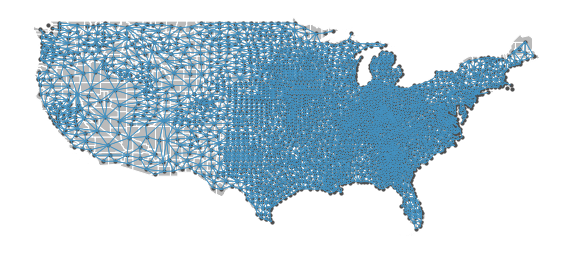

In [14]:
#Calculate weights object
weights = Queen.from_dataframe(votes)

#Use built in plot function to visualize how the weights matrix works
plot_spatial_weights(weights, votes)
plt.show()

The verticies in this plot represent two things: 
* First, they link "neigbors" based on the model parameters we set for defining neighborhood (here we use the defaul settings and consider any contiguous polygons). 
* The length of the verticies indicates the distance between the centers of neighborhing cells. 

"Neighbors" that are father matter less than "neighbors" that are closer in identifying the strength of spatial autocorrelation.

## Calculate Moran's I:
Moran's I statistic quantifies the spatial autocorrelation in your data. From https://en.wikipedia.org/wiki/Moran%27s_I
>"Spatial dependency leads to the spatial autocorrelation problem in statistics since, like temporal autocorrelation, this violates standard statistical techniques that assume independence among observations. For example, regression analyses that do not compensate for spatial dependency can have unstable parameter estimates and yield unreliable significance tests. Spatial regression models (see below) capture these relationships and do not suffer from these weaknesses. It is also appropriate to view spatial dependency as a source of information rather than something to be corrected."

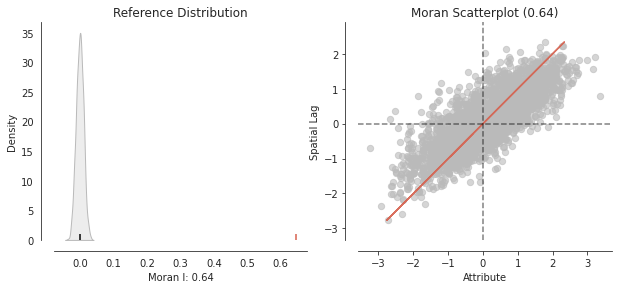

In [17]:
# calculate Moran and plot
moran_votes = Moran(votes['pct_dem_change'], w=weights)
plot_moran(moran_votes, zstandard=True, figsize=(10,4))
plt.show()

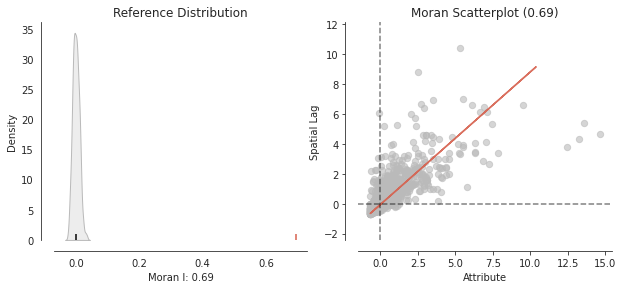

In [19]:
# calculate Moran and plot
moran_land = Moran(votes['ALAND'], w=weights)
plot_moran(moran_land, zstandard=True, figsize=(10,4))
plt.show()

### TASK 6: Do we have statistically significant evidence (at alpha = 0.05) of spatial autocorrelation in our response variable (Percent change in democratic vote, or pct_pt_16)?
Use code cell below as your "calculator". 

*

In [28]:
# What is the null hypothesis? Moran's I = 0
# What is the alternative hypothesis? Moran's I does not equal zero
# What is our test statistic? We can chose one of several test statistics, p-norm (p-value under normalization assumption), or p-rand (p-value under randomization)
# How can we derive the test statistic from our "moran" object?
# HINT
print("%.5f" % moran_votes.p_norm)
print("%.5f" % moran_land.p_norm)


0.00000
0.00000


## Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether that analysis determines a statistically significant relationship between our percent income and percent change in democratic vote.

In [30]:
#first, forumalate the model. See weather_trend.py in "Git_101" for a refresher on how.
from mlxtend.preprocessing import standardize
#standardize(X, columns=[0, 1])

#extract variable that you want to use to "predict"
X_raw = np.array(votes[['INC910213', 'ALAND']].values)
X = standardize(X_raw, columns=[0, 1])


#extract variable that we want to "predict"
Y = np.array(votes['pct_dem_change'].values)
# standardize them (calculate z-score) to help interpret coefficient magnitude
#Y = (Y - Y.mean())/Y.std()
Y= standardize(Y)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [36]:
X.shape

(3108, 2)

In [31]:
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.067
Model:                            OLS   Adj. R-squared (uncentered):              0.067
Method:                 Least Squares   F-statistic:                              112.2
Date:                Tue, 15 Nov 2022   Prob (F-statistic):                    8.70e-48
Time:                        04:07:18   Log-Likelihood:                         -4301.6
No. Observations:                3108   AIC:                                      8607.
Df Residuals:                    3106   BIC:                                      8619.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### TASK 7: Do we have statistically significant evidence (at alpha = 0.05) of a statistically significant relationship between pct_dem_change and INC910213 and ALAND? How does INC910213 and ALAND impact pct_dem_change? Use numbers to back your claim.

Answer:
Based on the values on "coef" column the impact of X1 (-0.0246) is nearly 30 times higher then X2 (-0.086).



Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values

In [37]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=lm.fit().resid

Remember, in OLS regression we depend out our residuals being normally distributed:

Text(0.5, 17.200000000000003, 'OLS residuals')

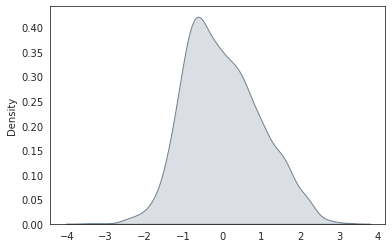

In [38]:
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('OLS residuals')

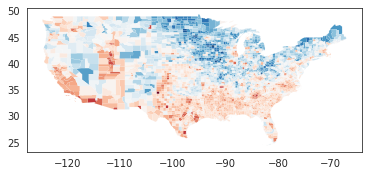

In [39]:
#Plot them in space:
votes.plot('lm_resid', linewidth=.05, cmap='RdBu')

These are very not normal residuals. What's going on?

### TASK 8: What does a positive residual mean here (the model overpredicted change in democratic vote, the model underpredicted change in democratic vote)?

Answer:
Positive residual means that the predicted value was too low or model underpredicted change in democratic vote.



One way we can evaluate whether spatial autocorrelation has impacted our results is if we see spatial autocorrelation in the residuals:

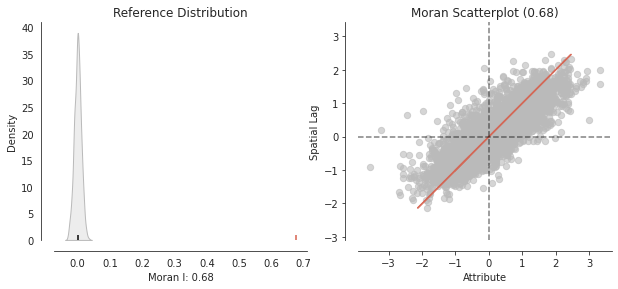

In [40]:
# calculate Moran and plot
moran = Moran(votes['lm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

### TASK 9: Do we have correlated residuals (use numbers to back your answer)?
Answer:

Based on the Moran value (0.68), yes we have correlated residuals.


Text(0, 0.5, 'linear model residuals')

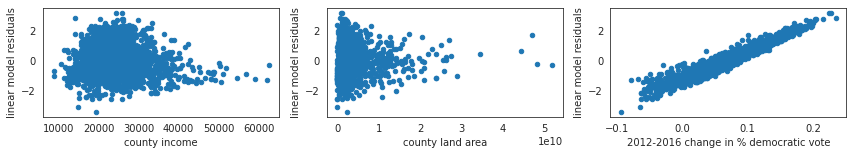

In [41]:
f,ax = plt.subplots(1,3, figsize=(3*3*1.6, 2))

votes[['INC910213','lm_resid']].plot.scatter('INC910213','lm_resid', ax=ax[0])
ax[0].set_xlabel('county income')
ax[0].set_ylabel('linear model residuals')

votes[['ALAND','lm_resid']].plot.scatter('ALAND','lm_resid', ax=ax[1])
ax[1].set_xlabel('county land area')
ax[1].set_ylabel('linear model residuals')

votes[['pct_dem_change','lm_resid']].plot.scatter('pct_dem_change','lm_resid', ax=ax[2])
ax[2].set_xlabel('2012-2016 change in % democratic vote')
ax[2].set_ylabel('linear model residuals')


*The first two plots show heteroskedasticity in our residuals. The second plot shows bias in our model*


## Autocovariate regression: spatial lag model
Let's see if we can get different answers by accounting for our residuals in our model. First, we'll try a spatial lag model. A spatial lag model is a type of autocovariate model that assumes that dependencies exist directly among the levels of the dependent variable, and models them as an "autocovariate". So we create an autocovariate function that describes the degree to which the percent change in democratic vote at one location is affected by the percent change in democratic vote at the nearby locations. The coefficient and p-value for the autocovariate function are interpreted as for the independent variables.

In [42]:
?spreg.ML_Lag

In [43]:
Yl = Y.T
Yl.shape = (len(Y),1)

lag=spreg.ML_Lag(Yl, X, weights, name_x=["income", "area"],name_y="vote", name_w="weights")
print(lag.summary)


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:784: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     weights
Dependent Variable  :        vote                Number of Observations:        3108
Mean dependent var  :     -0.0000                Number of Variables   :           4
S.D. dependent var  :      1.0002                Degrees of Freedom    :        3104
Pseudo R-squared    :      0.6739
Spatial Pseudo R-squared:  0.0119
Sigma-square ML     :       0.341                Log likelihood        :   -3005.539
S.E of regression   :       0.584                Akaike info criterion :    6019.079
                                                 Schwarz criterion     :    6043.246

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

Text(0.5, 17.200000000000003, 'SLM residuals')

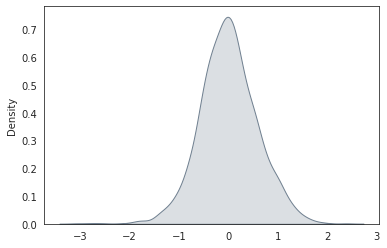

In [44]:
#Add model residuals to our "votes" geopandas dataframe:
votes['slm_resid']=lag.u
sns.kdeplot(votes['slm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('SLM residuals')

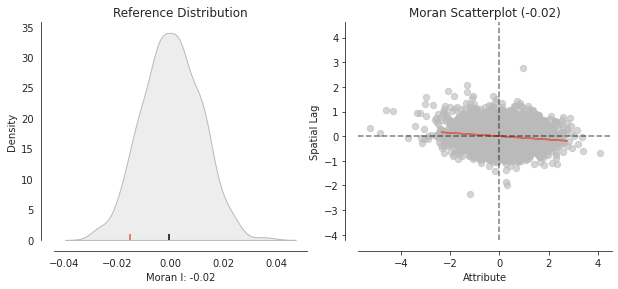

In [45]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

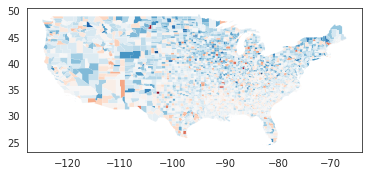

In [46]:
#Plot them in spac:
votes.plot('slm_resid', linewidth=.05, cmap='RdBu')

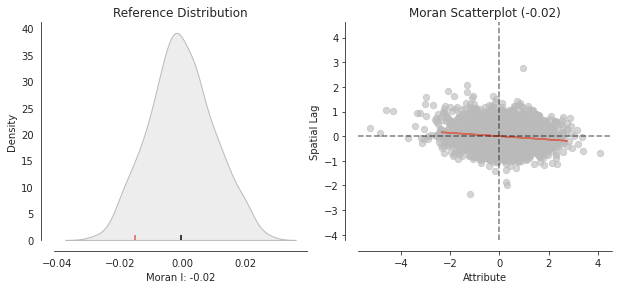

In [47]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [48]:
moran.p_norm

0.16744049373893588

Text(0, 0.5, 'spatial lag model residuals')

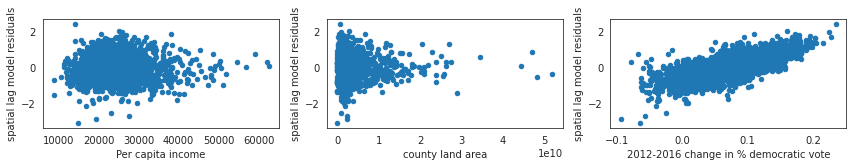

In [49]:
f,ax = plt.subplots(1,3, figsize=(3*3*1.6, 2))

votes[['INC910213','slm_resid']].plot.scatter('INC910213','slm_resid', ax=ax[0])
ax[0].set_xlabel('Per capita income')
ax[0].set_ylabel('spatial lag model residuals')

votes[['ALAND','slm_resid']].plot.scatter('ALAND','slm_resid', ax=ax[1])
ax[1].set_xlabel('county land area')
ax[1].set_ylabel('spatial lag model residuals')

votes[['pct_dem_change','slm_resid']].plot.scatter('pct_dem_change','slm_resid', ax=ax[2])
ax[2].set_xlabel('2012-2016 change in % democratic vote')
ax[2].set_ylabel('spatial lag model residuals')

### TASK 10: When we account for spatial autocorrelation in our data using the spatial lag model, do we still see a significant relationship between our response and predictor variables? Do you think this is a valid approach? Why or why not?

*Answer here*



## Spatial autoregressive model (maximum likelihood spatial error model)
Instead of modelling spatial dependence using an autocovariate, we use a similar type of weight structure (here called "lambda") to weight the error matrix:

In [50]:
MLerror = spreg.ML_Error(Yl, X, weights, name_x=["income", "area"],name_y="vote", name_w="weights")
print(MLerror.summary)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:784: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     weights
Dependent Variable  :        vote                Number of Observations:        3108
Mean dependent var  :     -0.0000                Number of Variables   :           3
S.D. dependent var  :      1.0002                Degrees of Freedom    :        3105
Pseudo R-squared    :      0.0617
Sigma-square ML     :       0.311                Log likelihood        :   -2883.754
S.E of regression   :       0.558                Akaike info criterion :    5773.508
                                                 Schwarz criterion     :    5791.633

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

Text(0.5, 17.200000000000003, 'MLError residuals')

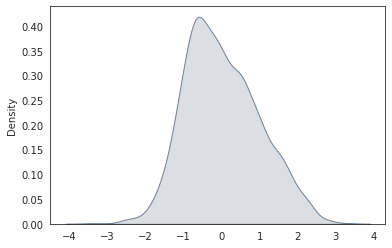

In [51]:
#Add model residuals to our "votes" geopandas dataframe:
votes['mlError_resid']=MLerror.u
sns.kdeplot(votes['mlError_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('MLError residuals')

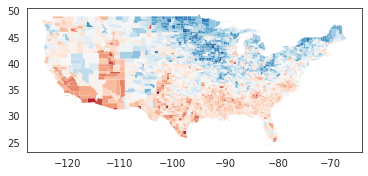

In [52]:
#Plot them in spac:
votes.plot('mlError_resid', linewidth=.05, cmap='RdBu')

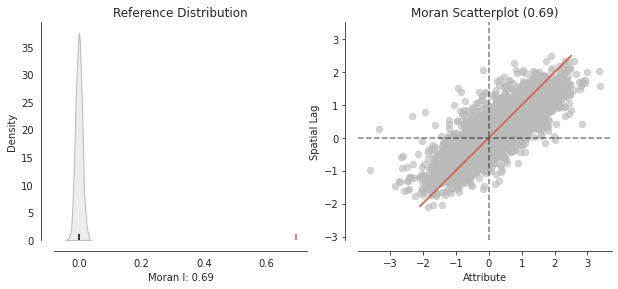

In [53]:
# calculate Moran and plot
moran = Moran(votes['mlError_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [54]:
moran.p_norm

0.0

Text(0, 0.5, 'autoregressive model residuals')

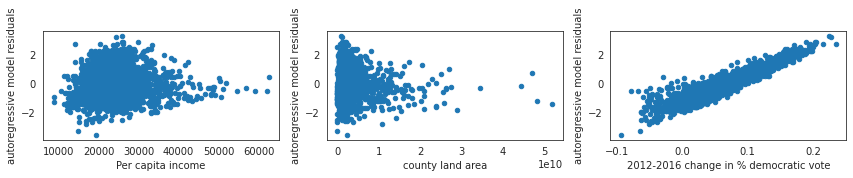

In [55]:
f,ax = plt.subplots(1,3, figsize=(3*3*1.6, 2))

votes[['INC910213','mlError_resid']].plot.scatter('INC910213','mlError_resid', ax=ax[0])
ax[0].set_xlabel('Per capita income')
ax[0].set_ylabel('autoregressive model residuals')

votes[['ALAND','mlError_resid']].plot.scatter('ALAND','mlError_resid', ax=ax[1])
ax[1].set_xlabel('county land area')
ax[1].set_ylabel('autoregressive model residuals')

votes[['pct_dem_change','mlError_resid']].plot.scatter('pct_dem_change','mlError_resid', ax=ax[2])
ax[2].set_xlabel('2012-2016 change in % democratic vote')
ax[2].set_ylabel('autoregressive model residuals')

### TASK 11: Given these three models, do you believe that there is a linear relationship between percent change in democratic vote and income level? What about between change in democratic vote and land area? Why or why not?

